# Image metadata

2025-10-27 10:57:54.728 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-10-27 10:57:55.198 | INFO     | wings.config:<module>:62 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'


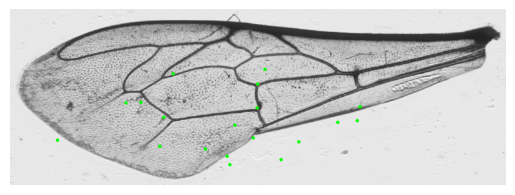

In [1]:
import cv2
import numpy as np
import torch
from PIL import Image

from wings.visualizing.visualize import visualize_coords

# open the image
path = "img.png"
image = Image.open(path)
image.load()

s = image.info['IdentiFly']

part = s.split("landmarks:")[1].split(";")[0]

# zamień na listę liczb
numbers = [int(x) for x in part.split()]
# ułóż w tablicę (n, 2)
landmarks = np.array(numbers).reshape(-1, 2)

# print(landmarks)

img = cv2.imread(path, cv2.IMREAD_COLOR)
img = visualize_coords(img, torch.tensor(numbers), spot_size=3)


In [2]:
from wings.modeling.loss import DiceLoss
from wings.modeling.litnet import LitNet
from wings.config import PROCESSED_DATA_DIR, MODELS_DIR
import torch

mean_coords = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "mean_shape.pth", weights_only=False
)

checkpoint_path = MODELS_DIR / 'unet-rectangle-epoch=08-val_loss=0.14-unet-training-rectangle_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()


Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


LitNet(
  (model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNor

In [3]:
from tqdm import tqdm
import os
from wings.config import RAW_DATA_DIR
from wings.gpa import recover_order, procrustes_align, normalize_shape, center_shape
from wings.visualizing.image_preprocess import unet_fit_rectangle_preprocess, final_coords
from wings.utils import load_image
from PIL import Image
import numpy as np
import torch

original_labels = []
predicted_labels = []
bad_masks = 0
bad_indices = []
group_indices = []
gpas = []

directory = RAW_DATA_DIR / "pulawy" / "01_00_01"

all_files = []
for subdir, _, files in os.walk(directory):
    for file in files:
        if file.lower().endswith('.png'):
            img_path = os.path.join(subdir, file)
            all_files.append(img_path)

for idx, img_path in enumerate(tqdm(all_files, desc="Processing images")):
    try:
        image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
        if x_size == 5782:
            group_indices.append(idx)
            continue
        output = model(image_tensor.cuda().unsqueeze(0))
        mask = torch.round(output).squeeze().detach().cpu().numpy()

        mask_coords = final_coords(mask, x_size, y_size)
        reordered = recover_order(mean_coords, torch.tensor(mask_coords))
        gpa = procrustes_align(normalize_shape(center_shape(reordered)), mean_coords)
        gpas.append(gpa.cpu().numpy())
        predicted_labels.append(reordered.cpu().numpy())

        img = Image.open(img_path)
        img.load()
        meta = img.info['IdentiFly']
        orig = meta.split("landmarks:")[1].split(";")[0]
        labels = [int(x) for x in orig.split()]
        coordinates = np.array(labels).reshape(-1, 2)
        coordinates[:, 1] = y_size - coordinates[:, 1] - 1
        original_labels.append(coordinates)

    except Exception:
        bad_masks += 1
        bad_indices.append(idx)
        continue

print(f"Total samples: {len(original_labels) + bad_masks}")
print(f"Failed masks: {bad_masks}")

original_labels = np.stack(original_labels)
predicted_labels = np.stack(predicted_labels)
gpas = np.stack(gpas)

print(f"{original_labels.shape=}")
print(f"{predicted_labels.shape=}")
print(f"{gpas.shape=}")


Processing images: 100%|██████████| 1092/1092 [00:34<00:00, 31.60it/s]

Total samples: 1012
Failed masks: 83
original_labels.shape=(929, 19, 2)
predicted_labels.shape=(929, 19, 2)
gpas.shape=(929, 19, 2)


In [4]:
errors = np.linalg.norm(predicted_labels - original_labels, axis=2)  # shape: (n_samples, 19)
gpa_errors = np.linalg.norm(mean_coords.cpu().numpy() - gpas, axis=2)
errors.size


17651

In [5]:
import pandas as pd

mean = errors.mean()
median = np.median(errors)

mean_error = errors.mean(axis=0)
min_error = errors.min(axis=0)
max_error = errors.max(axis=0)

rmse_error = np.sqrt(np.mean(errors ** 2, axis=0))
median_error = np.median(errors, axis=0)

df = pd.DataFrame(
    {
        "MAE": mean_error,
        "RMSE": rmse_error,
        "Median": median_error,
        "Min": min_error,
        "Max": max_error,
    }, index=np.arange(1, 20)
)

print(f"{mean=}")
print(f"{median=}\n")

df.index.name = "Point"
df = df.round(3)

print(df)


mean=np.float64(2.7280124109183617)
median=np.float64(2.18278975695278)

         MAE   RMSE  Median    Min      Max
Point                                      
1      2.536  4.986   2.328  0.073  128.628
2      2.148  2.571   2.047  0.074   29.478
3      2.085  2.398   2.003  0.071   14.487
4      2.703  3.329   2.584  0.122   49.761
5      1.868  2.122   1.787  0.035   11.780
6      2.311  2.619   2.290  0.042   18.339
7      6.296  6.656   5.942  1.285   21.823
8      1.917  2.195   1.733  0.086    6.830
9      1.624  1.865   1.515  0.176   13.304
10     1.598  1.792   1.498  0.052    4.991
11     1.814  2.045   1.718  0.059    6.075
12     1.787  2.003   1.744  0.059    9.235
13     1.965  2.260   1.901  0.066   18.314
14     8.901  9.304   8.822  2.287   18.035
15     2.021  2.271   1.958  0.124    8.401
16     2.587  2.830   2.529  0.132    8.910
17     2.353  2.595   2.303  0.047    6.533
18     2.519  2.763   2.521  0.074    6.833
19     2.801  3.239   2.547  0.102   10.655


In [6]:
mean_per_image = errors.mean(axis=1)
# mean_per_image = np.sqrt(np.mean(errors**2, axis=1))
gpa_error_per_image = gpa_errors.mean(axis=1)

mae = np.mean(np.abs(mean_per_image))
rmse = np.sqrt(np.mean(mean_per_image ** 2))
median_error = np.median(mean_per_image)
min_error = np.min(mean_per_image)
max_error = np.max(mean_per_image)

df = pd.DataFrame(
    {
        "MAE": [mae],
        "RMSE": [rmse],
        "Median": [median_error],
        "Min": [min_error],
        "Max": [max_error]
    }
).round(3)

print(df)


     MAE   RMSE  Median    Min     Max
0  2.728  2.764   2.691  1.855  10.661


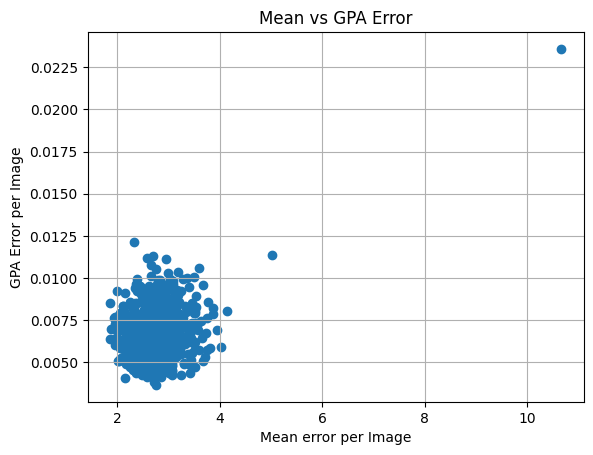

In [29]:
import matplotlib.pyplot as plt

max_error_per_image = np.max(errors, axis=1)

plt.figure()
plt.scatter(mean_per_image, gpa_error_per_image)

plt.title("Mean vs GPA Error")
plt.xlabel("Mean error per Image")
plt.ylabel("GPA Error per Image")
plt.grid(True)
# plt.xlim(0, 25)
plt.show()


In [8]:
import numpy as np

n = 10

flat_errors = errors.flatten()

# Get indices of top-n largest errors
top_n_flat_indices = np.argpartition(-flat_errors, n)[:n]
top_n_flat_indices = top_n_flat_indices[np.argsort(-flat_errors[top_n_flat_indices])]

# Convert back to 2D indices (sample index, inner index)
top_n_indices_2d = np.array(np.unravel_index(top_n_flat_indices, errors.shape)).T  # shape: (n, 2)
top_n_sample_indices = top_n_indices_2d[:, 0]

all_indices = list(range(len(all_files)))
good_indices = [i for i in all_indices if (i not in bad_indices) and (i not in group_indices)]

original_dataset_indices_per_point = [good_indices[i] for i in top_n_sample_indices]

print("Top-n errors (dataset_index, point, error_value):")
for idx, ((sample_idx, inner_idx), dataset_idx) in enumerate(zip(top_n_indices_2d, original_dataset_indices_per_point)):
    print(
        f"{idx + 1:2.0f}:\tIndex={dataset_idx:5.0f}\t\tPoint {inner_idx+1:2.0f}\tError={errors[sample_idx, inner_idx]:7.2f}"
    )

print(original_dataset_indices_per_point)


Top-n errors (dataset_index, point, error_value):
 1:	Index=  728		Point  1	Error= 128.63
 2:	Index=   26		Point  4	Error=  49.76
 3:	Index=  728		Point  2	Error=  29.48
 4:	Index=   38		Point  7	Error=  21.82
 5:	Index=  265		Point  6	Error=  18.34
 6:	Index=  592		Point 13	Error=  18.31
 7:	Index=  750		Point 14	Error=  18.03
 8:	Index=  285		Point 14	Error=  17.71
 9:	Index=  598		Point 14	Error=  17.23
10:	Index=  740		Point 14	Error=  16.75
[728, 26, 728, 38, 265, 592, 750, 285, 598, 740]


In [9]:
import numpy as np

n = 10

mean_errors_per_image = np.mean(errors, axis=1)  # shape: (n_images,)

top_n_indices = np.argpartition(-mean_errors_per_image, n)[:n]
top_n_indices = top_n_indices[np.argsort(-mean_errors_per_image[top_n_indices])]

all_indices = list(range(len(all_files)))
good_indices = [i for i in all_indices if (i not in bad_indices) and (i not in group_indices)]
original_dataset_indices_per_image = [good_indices[i] for i in top_n_indices]

print("Top-n images with largest mean error (dataset_index, mean_error):")
for rank, (sample_idx, dataset_idx) in enumerate(zip(top_n_indices, original_dataset_indices_per_image), start=1):
    print(f"{rank:2}: Index={dataset_idx:5}\t\tMean error={mean_errors_per_image[sample_idx]:7.3f}")


Top-n images with largest mean error (dataset_index, mean_error):
 1: Index=  728		Mean error= 10.661
 2: Index=   26		Mean error=  5.023
 3: Index=  655		Mean error=  4.144
 4: Index=  512		Mean error=  4.029
 5: Index=  548		Mean error=  3.946
 6: Index=  895		Mean error=  3.860
 7: Index=   80		Mean error=  3.856
 8: Index=  560		Mean error=  3.814
 9: Index=  186		Mean error=  3.777
10: Index= 1075		Mean error=  3.752


In [9]:
threshold = 3.5

num_errors_above_threshold = np.sum(errors > threshold)
total_points = errors.size
percentage = (num_errors_above_threshold / total_points) * 100

print(f"Number of points with error > {threshold}: {num_errors_above_threshold}")
print(f"Percent of all points: {percentage:.2f}%")


Number of points with error > 3.5: 3575
Percent of all points: 20.25%


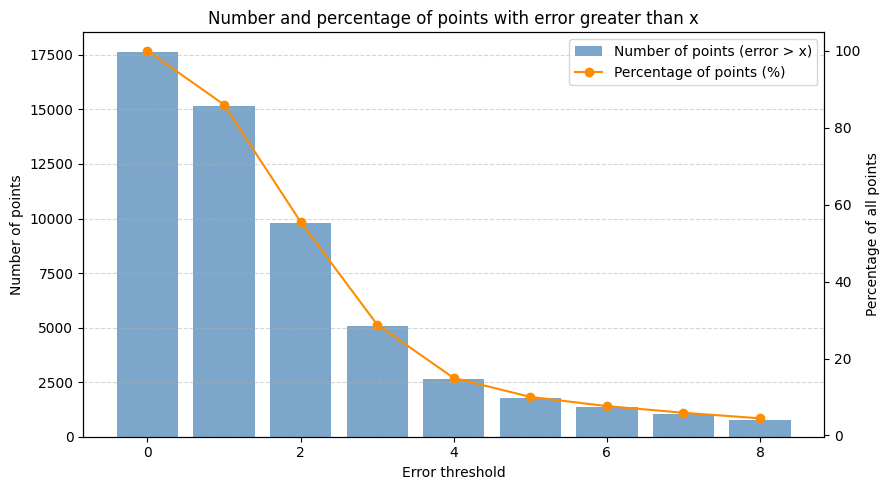

In [10]:
import numpy as np
import matplotlib.pyplot as plt

flat_errors = errors.flatten()
# m = int(np.ceil(flat_errors.max()))
m = 8

x_values = np.arange(0, m + 1)

counts = [np.sum(flat_errors > x) for x in x_values]
percentages = [100 * c / len(flat_errors) for c in counts]

# Graph
fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.bar(x_values, counts, color='steelblue', alpha=0.7, label='Number of points (error > x)')
ax1.set_xlabel('Error threshold')
ax1.set_ylabel('Number of points')
# ax1.set_yscale('log')  # logaritmic scale
ax1.grid(True, which="both", axis='y', linestyle='--', alpha=0.5)
ax1.set_title('Number and percentage of points with error greater than x')

ax2 = ax1.twinx()
ax2.plot(x_values, percentages, color='darkorange', marker='o', label='Percentage of points (%)')
ax2.set_ylabel('Percentage of all points')

# ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()


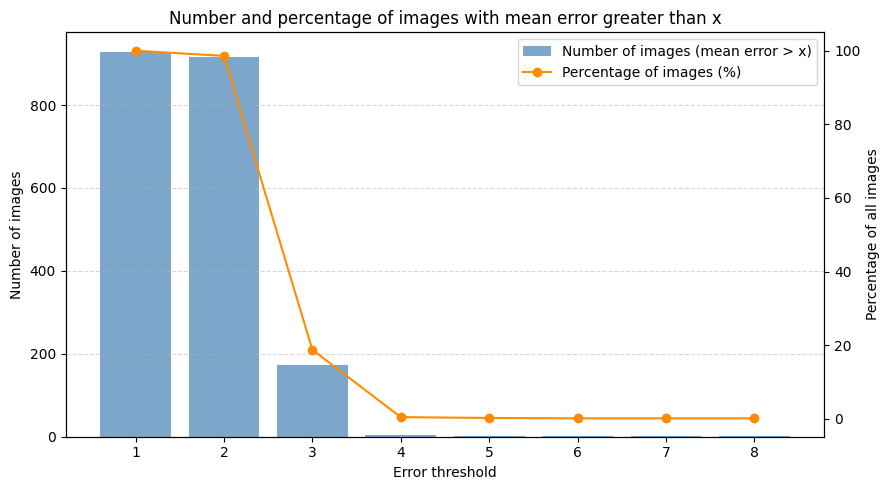

In [11]:
import numpy as np
import matplotlib.pyplot as plt

mean_errors_per_image = np.mean(errors, axis=1)

m = 8
x_values = np.arange(1, m + 1)

counts = [np.sum(mean_errors_per_image > x) for x in x_values]
percentages = [100 * c / len(mean_errors_per_image) for c in counts]

fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.bar(x_values, counts, color='steelblue', alpha=0.7, label='Number of images (mean error > x)')
ax1.set_xlabel('Error threshold')
ax1.set_ylabel('Number of images')
ax1.grid(True, which="both", axis='y', linestyle='--', alpha=0.5)
ax1.set_title('Number and percentage of images with mean error greater than x')

ax2 = ax1.twinx()
ax2.plot(x_values, percentages, color='darkorange', marker='o', label='Percentage of images (%)')
ax2.set_ylabel('Percentage of all images')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()


In [12]:
threshold = 3

mean_errors_per_image = np.mean(errors, axis=1)

num_images_above_threshold = np.sum(mean_errors_per_image > threshold)
total_images = len(mean_errors_per_image)
percentage = (num_images_above_threshold / total_images) * 100

print(f"Number of images with mean error > {threshold}: {num_images_above_threshold}")
print(f"Percent of all images: {percentage:.2f}%")


Number of images with mean error > 3: 174
Percent of all images: 18.73%


In [15]:
values = original_dataset_indices_per_image
values_iter = iter(values)
max_n = len(good_indices)


928 315
655


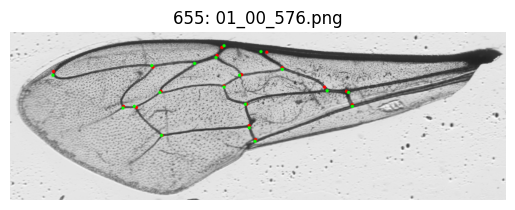

In [28]:
from pathlib import Path
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.image_preprocess import final_coords
import cv2
from wings.config import RAW_DATA_DIR, IMG_FOLDER_SUFX

# n = np.random.randint(0, max_n)
# n = 728
try:
    n = next(values_iter)
except StopIteration:
    values_iter = iter(values)
    n = next(values_iter)


img_path = all_files[n]
image_tensor, x_size, y_size = load_image(img_path, unet_fit_rectangle_preprocess)
print(x_size, y_size)
output = model(image_tensor.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()

mask_coords = final_coords(mask, x_size, y_size)
reordered = recover_order(mean_coords, torch.tensor(mask_coords))

img = Image.open(img_path)
img.load()
meta = img.info['IdentiFly']
orig = meta.split("landmarks:")[1].split(";")[0]
labels = [int(x) for x in orig.split()]
coordinates = np.array(labels).reshape(-1, 2)
coordinates[:, 1] = y_size - coordinates[:, 1] - 1


# Visualize
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
spot_size = 3
print(n)
filename = Path(img_path).name
img = visualize_coords(img, coordinates.flatten(), spot_size=spot_size, color=(255, 0, 0), show=False)
img = visualize_coords(img, reordered.flatten(), spot_size=spot_size, color=(0, 255, 0), filename=f"{n}: {filename}")
